# RAGDA DR training

In [ ]:
#| default_exp 78-radga-dr-ep-for-wikiseealso-1-0

In [ ]:
%load_ext autoreload
%autoreload 2

from nbdev.showdoc import *
import nbdev; nbdev.nbdev_export()

In [ ]:
#| export
import os,torch, torch.multiprocessing as mp, pickle
from xcai.basics import *
from xcai.models.radga import RAD006

comet_ml is installed but `COMET_API_KEY` is not set.


In [ ]:
os.environ['WANDB_MODE'] = 'disabled'

In [ ]:
#| export
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
os.environ['WANDB_PROJECT']='xc-nlg_66-radga-dr-ep-for-wikiseealso-2'

In [ ]:
data_dir = '/home/scai/phd/aiz218323/Projects/XC_NLG/data'

In [ ]:
#| export
pkl_dir = '/home/scai/phd/aiz218323/scratch/datasets/'
pkl_file = f'{pkl_dir}/processed/wikiseealso_data-metas_distilbert-base-uncased_rm_radga-cat-linker.pkl'

In [ ]:
with open(pkl_file, 'wb') as file: pickle.dump(block, file)

In [ ]:
#| export
with open(pkl_file, 'rb') as file: block = pickle.load(file)

In [ ]:
#| export
with open(f'{pkl_dir}/processed/corelations.pkl', 'rb') as file: data_corel, lbl_corel = pickle.load(file)

from xcai.data import MetaXCDataset, XCDataset
from scipy import sparse

lco_meta = MetaXCDataset('lco', sparse.csr_matrix((block.train.dset.n_data, block.n_lbl)), lbl_corel, 
                         block.train.dset.data.lbl_info)

block.train.dset.meta['lco_meta'] = lco_meta

In [ ]:
#| export
from xcai.data import MetaXCDataset
block.train.dset.meta['hyb_meta'] = block.train.dset.meta['cat_meta']
block.test.dset.meta['hyb_meta'] = block.train.dset.meta['lnk_meta']

In [ ]:
#| export
block.train.dset.meta['hyb_meta'] = MetaXCDataset('hyb', block.train.dset.meta['cat_meta'].data_meta, 
                                                  block.train.dset.meta['cat_meta'].lbl_meta,
                                                  block.train.dset.meta['cat_meta'].meta_info)
block.test.dset.meta['hyb_meta'] = MetaXCDataset('hyb', block.train.dset.meta['lnk_meta'].data_meta, 
                                                  block.train.dset.meta['lnk_meta'].lbl_meta,
                                                  block.train.dset.meta['lnk_meta'].meta_info)

In [ ]:
#| export
block.collator.tfms.tfms[0].smp_features = [('lbl2data|hyb2lbl2data|lco2lbl2data', 1, (1,3,1)), 
                                            ('hyb2data',1,3)]

## Linker prediction confidence

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
lnk_meta = block.test.dset.meta['lnk_meta'].data_meta.copy()

In [ ]:
block.test.dset.meta['lnk_meta'].data_meta = lnk_meta.copy()

In [ ]:
x = block.test.dset.meta['lnk_meta'].data_meta

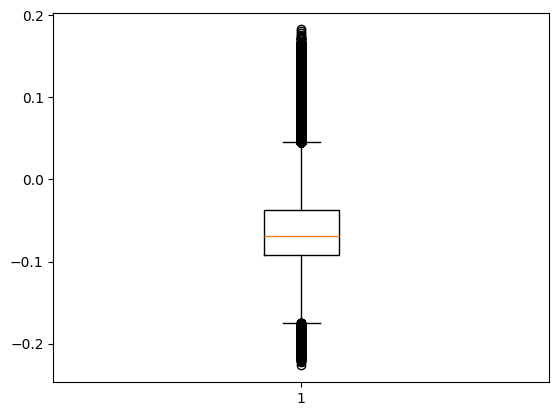

In [ ]:
o = plt.boxplot(x.data)

In [ ]:
o['medians'][0].get_data()

(array([0.925, 1.075]), array([-0.06835106, -0.06835106]))

In [ ]:
o

{'whiskers': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'caps': [<matplotlib.lines.Line2D>,
  <matplotlib.lines.Line2D>],
 'boxes': [<matplotlib.lines.Line2D>],
 'medians': [<matplotlib.lines.Line2D>],
 'fliers': [<matplotlib.lines.Line2D>],
 'means': []}

In [ ]:
np.sum(x.data > -0.06835106)/x.data.shape[0], 

(0.4999994366673239,)

In [ ]:
np.sum(x.getnnz(axis=1) != 0)/x.shape[0]

1.0

## Training

In [ ]:
#| export
args = XCLearningArguments(
    output_dir='/home/scai/phd/aiz218323/scratch/outputs/78-radga-dr-ep-for-wikiseealso-1-0',
    logging_first_step=True,
    per_device_train_batch_size=10, #800,
    per_device_eval_batch_size=800,
    representation_num_beams=200,
    representation_accumulation_steps=10,
    save_strategy="steps",
    evaluation_strategy="steps",
    eval_steps=10, #5000,
    save_steps=10, #5000,
    save_total_limit=5,
    num_train_epochs=300,
    predict_with_representation=True,
    adam_epsilon=1e-6,
    warmup_steps=100,
    weight_decay=0.01,
    learning_rate=2e-4,
    generation_num_beams=10,
    generation_length_penalty=1.5,
    predict_with_generation=True,
    representation_search_type='BRUTEFORCE',
    
    output_representation_attribute='data_fused_repr',
    label_representation_attribute='data_repr',
    metadata_representation_attribute='data_repr',
    data_augmentation_attribute='data_repr',
    representation_attribute='data_fused_repr',
    clustering_representation_attribute='data_fused_repr',
    
    group_by_cluster=True,
    num_clustering_warmup_epochs=10,
    num_cluster_update_epochs=5,
    num_cluster_size_update_epochs=25,
    use_data_metadata_for_clustering=True,
    clustering_type='EXPO',
    minimum_cluster_size=2,
    maximum_cluster_size=1600,

    metric_for_best_model='P@1',
    load_best_model_at_end=True,
    target_indices_key='plbl2data_idx',
    target_pointer_key='plbl2data_data2ptr',
    
    use_distributional_representation=False,
    use_encoder_parallel=True,
    max_grad_norm=None, 
    fp16=True,
    
    label_names=['hyb2data_idx', 'hyb2data_input_ids', 'hyb2data_attention_mask', 
                 'lco2lbl2data_idx', 'lco2lbl2data_input_ids', 'lco2lbl2data_attention_mask'],

    prune_metadata=False,
    num_metadata_prune_warmup_epochs=10,
    num_metadata_prune_epochs=5,
    metadata_prune_batch_size=2048,
    prune_metadata_names=['cat_meta'],
    use_data_metadata_for_pruning=True,

    predict_with_augmentation=False,
    use_augmentation_index_representation=True,
    
    data_aug_meta_name='hyb',
    augmentation_num_beams=3,
    data_aug_prefix='hyb',
    use_label_metadata=False,
    
    data_meta_batch_size=2048,
    augment_metadata=False,
    num_metadata_augment_warmup_epochs=10,
    num_metadata_augment_epochs=5,
)

In [ ]:
#| export
metric = PrecRecl(block.n_lbl, block.test.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[10, 100, 200])

In [ ]:
#| export
bsz = max(args.per_device_train_batch_size, args.per_device_eval_batch_size)*torch.cuda.device_count()

model = RAD006.from_pretrained('sentence-transformers/msmarco-distilbert-base-v4', batch_size=bsz, num_batch_labels=5000, 
                               margin=0.3, num_negatives=10, tau=0.1, apply_softmax=True,
                               
                               data_aug_meta_prefix='hyb2data', lbl2data_aug_meta_prefix=None, 
                               data_pred_meta_prefix=None, lbl2data_pred_meta_prefix='lco2lbl',

                               resize_length=5000, use_noise=True, shuffle_noise_pct=0.4, dropout_noise_pct=0.1,
                               
                               use_query_loss=True,

                               calib_margin=0.3, calib_num_negatives=10, calib_tau=0.1, calib_apply_softmax=True, calib_loss_weight=1.0,
                               use_calib_loss= True,
                               
                               meta_loss_weight=0.1, fusion_loss_weight=0.1, use_fusion_loss=True,
                               use_encoder_parallel=False)

model.init_retrieval_head()
model.init_cross_head()

Some weights of RAD006 were not initialized from the model checkpoint at sentence-transformers/msmarco-distilbert-base-v4 and are newly initialized: ['encoder.cross_head.k.bias', 'encoder.cross_head.k.weight', 'encoder.cross_head.o.bias', 'encoder.cross_head.o.weight', 'encoder.cross_head.q.bias', 'encoder.cross_head.q.weight', 'encoder.cross_head.v.bias', 'encoder.cross_head.v.weight', 'encoder.dr_head.layer_norm.bias', 'encoder.dr_head.layer_norm.weight', 'encoder.dr_head.projector.bias', 'encoder.dr_head.projector.weight', 'encoder.dr_head.transform.bias', 'encoder.dr_head.transform.weight', 'encoder.meta_head.layer_norm.bias', 'encoder.meta_head.layer_norm.weight', 'encoder.meta_head.projector.bias', 'encoder.meta_head.projector.weight', 'encoder.meta_head.transform.bias', 'encoder.meta_head.transform.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#| export
learn = XCLearner(
    model=model, 
    args=args,
    train_dataset=block.train.dset,
    eval_dataset=block.test.dset,
    data_collator=block.collator,
    compute_metrics=metric,
)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
learn.train()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,P@1,P@10,P@3,P@5,N@1,N@10,N@3,N@5,Psp@1,Psp@10,Psp@3,Psp@5,Psn@1,Psn@10,Psn@3,Psn@5,R@200,R@10,R@100
10,0.057500,0.091941,0.031192,0.015662,0.024777,0.020936,0.031192,0.046263,0.034856,0.039018,0.029736,0.059418,0.037319,0.044376,0.029736,0.049621,0.036278,0.041469,0.218210,0.066099,0.172323


  0%|          | 0/196 [00:00<?, ?it/s]

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
Checkpoint destination directory /home/scai/phd/aiz218323/scratch/outputs/78-radga-dr-ep-for-wikiseealso-1-0/checkpoint-10 already exists and is non-empty. Saving will proceed but saved results may be invalid.


  0%|          | 0/196 [00:00<?, ?it/s]

In [ ]:
#| export
if __name__ == '__main__':
    mp.freeze_support()
    learn.train()
    

## Prediction

In [ ]:
args = XCLearningArguments(
    output_dir='/home/scai/phd/aiz218323/scratch/outputs/72-radga-dr-ep-for-wikiseealso-1-0',
    logging_first_step=True,
    per_device_train_batch_size=800,
    per_device_eval_batch_size=800,
    representation_num_beams=200,
    representation_accumulation_steps=10,
    save_strategy="steps",
    evaluation_strategy="steps",
    eval_steps=5000,
    save_steps=5000,
    save_total_limit=5,
    num_train_epochs=300,
    predict_with_representation=True,
    adam_epsilon=1e-6,
    warmup_steps=100,
    weight_decay=0.01,
    learning_rate=2e-4,
    generation_num_beams=10,
    generation_length_penalty=1.5,
    predict_with_generation=True,
    representation_search_type='INDEX',
    
    output_representation_attribute='data_fused_repr',
    label_representation_attribute='data_repr',
    metadata_representation_attribute='data_repr',
    data_augmentation_attribute='data_repr',
    representation_attribute='data_repr',
    clustering_representation_attribute='data_fused_repr',
    
    group_by_cluster=True,
    num_clustering_warmup_epochs=10,
    num_cluster_update_epochs=5,
    num_cluster_size_update_epochs=25,
    use_data_metadata_for_clustering=True,
    clustering_type='EXPO',
    minimum_cluster_size=2,
    maximum_cluster_size=1600,

    metric_for_best_model='P@1',
    load_best_model_at_end=True,
    target_indices_key='plbl2data_idx',
    target_pointer_key='plbl2data_data2ptr',
    
    use_distributional_representation=False,
    use_encoder_parallel=True,
    max_grad_norm=None, 
    fp16=True,
    
    label_names=['cat2data_idx', 'cat2data_input_ids', 'cat2data_attention_mask'],

    prune_metadata=False,
    num_metadata_prune_warmup_epochs=10,
    num_metadata_prune_epochs=5,
    metadata_prune_batch_size=2048,
    prune_metadata_names=['cat_meta'],
    use_data_metadata_for_pruning=True,

    predict_with_augmentation=False,
    use_augmentation_index_representation=True,
    
    data_aug_meta_name='cat',
    augmentation_num_beams=3,
    data_aug_prefix='cat',
    use_label_metadata=False,
    
    data_meta_batch_size=2048,
    augment_metadata=False,
    num_metadata_augment_warmup_epochs=10,
    num_metadata_augment_epochs=5,
)

In [ ]:
metric = PrecRecl(block.n_lbl, block.test.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[10, 100, 200])

In [ ]:
bsz = max(args.per_device_train_batch_size, args.per_device_eval_batch_size)*torch.cuda.device_count()

model = RAD002.from_pretrained('distilbert-base-uncased', num_batch_labels=5000, batch_size=bsz,
                               margin=0.3, num_negatives=5, tau=0.1, apply_softmax=True,
                               
                               data_aug_meta_prefix='cat2data', lbl2data_aug_meta_prefix=None, 
                               data_pred_meta_prefix=None, lbl2data_pred_meta_prefix=None,
                               
                               resize_length=5000, use_noise=True, noise_percent=0.5,
                               
                               meta_loss_weight=0.3, fusion_loss_weight=0.1, 
                               use_fusion_loss=False,  use_encoder_parallel=True)

model.init_retrieval_head()
model.init_cross_head()

Some weights of RAD002 were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['encoder.cross_head.k.bias', 'encoder.cross_head.k.weight', 'encoder.cross_head.o.bias', 'encoder.cross_head.o.weight', 'encoder.cross_head.q.bias', 'encoder.cross_head.q.weight', 'encoder.cross_head.v.bias', 'encoder.cross_head.v.weight', 'encoder.dr_head.layer_norm.bias', 'encoder.dr_head.layer_norm.weight', 'encoder.dr_head.projector.bias', 'encoder.dr_head.projector.weight', 'encoder.dr_head.transform.bias', 'encoder.dr_head.transform.weight', 'encoder.meta_head.layer_norm.bias', 'encoder.meta_head.layer_norm.weight', 'encoder.meta_head.projector.bias', 'encoder.meta_head.projector.weight', 'encoder.meta_head.transform.bias', 'encoder.meta_head.transform.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
learn = XCLearner(
    model=model, 
    args=args,
    train_dataset=block.train.dset,
    eval_dataset=block.test.dset,
    data_collator=block.collator,
    compute_metrics=metric,
)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
